In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [41]:
transform = transforms.ToTensor()

# Download and load the MNIST training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

normal_label = 9
anomalie_label = 5

# Filter the dataset to include only images with label normal and 5
label_normal_indices = [i for i, (_, label) in enumerate(train_data) if label == normal_label]
label_anomalie_indices = [i for i, (_, label) in enumerate(train_data) if label == anomalie_label]
label_normal_indices_test = [i for i, (_, label) in enumerate(test_data) if label == normal_label]
label_anomalie_indices_test = [i for i, (_, label) in enumerate(test_data) if label == anomalie_label]

# Calculate the number of samples for each label based on the desired proportions
num_label_normal = int(0.95 * len(label_normal_indices))
num_label_anomalie = int(0.05 * len(label_anomalie_indices))


# Randomly sample images with label 9 and label 5
selected_label_normal_indices = np.random.choice(label_normal_indices, num_label_normal, replace=False)
selected_label_anomalie_indices = np.random.choice(label_anomalie_indices, num_label_anomalie, replace=False)

# Combine the selected indices
selected_indices_train = np.concatenate([selected_label_normal_indices, selected_label_anomalie_indices])
selected_indices_test = np.concatenate([label_normal_indices_test, label_anomalie_indices_test])

# Create a Subset of the original dataset with the selected indices
filtered_dataset = torch.utils.data.Subset(train_data, selected_indices_train)
filtered_dataset_test = torch.utils.data.Subset(test_data, selected_indices_test)

print("Len Train:", len(filtered_dataset))
print("Len Test:", len(filtered_dataset_test))

# Create a DataLoader to iterate through the filtered dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
train_loader_without_batch = torch.utils.data.DataLoader(filtered_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(filtered_dataset_test, shuffle=True)

Len Train: 5922
Len Test: 1901


In [35]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [36]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [37]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-5)

# Point to training loop video
num_epochs = 30
outputs = []
for epoch in range(num_epochs):
    imgs = []
    for (img, _) in train_loader:
        recon = model(img)
        loss = criterion(recon, img)
        imgs.append((img, loss))

    imgs.sort(key=lambda x: x[1])
    l = int(0.5 * len(imgs))
    imgs = imgs[:l]

    optimizer.zero_grad()

    for (img, _) in imgs:
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.1749
Epoch:2, Loss:0.0889
Epoch:3, Loss:0.0612
Epoch:4, Loss:0.0561
Epoch:5, Loss:0.0538
Epoch:6, Loss:0.0529
Epoch:7, Loss:0.0519
Epoch:8, Loss:0.0519
Epoch:9, Loss:0.0515
Epoch:10, Loss:0.0509
Epoch:11, Loss:0.0509
Epoch:12, Loss:0.0510
Epoch:13, Loss:0.0509
Epoch:14, Loss:0.0510
Epoch:15, Loss:0.0507
Epoch:16, Loss:0.0504
Epoch:17, Loss:0.0501
Epoch:18, Loss:0.0497
Epoch:19, Loss:0.0492
Epoch:20, Loss:0.0474
Epoch:21, Loss:0.0454
Epoch:22, Loss:0.0431
Epoch:23, Loss:0.0417
Epoch:24, Loss:0.0391
Epoch:25, Loss:0.0379
Epoch:26, Loss:0.0362
Epoch:27, Loss:0.0342
Epoch:28, Loss:0.0334
Epoch:29, Loss:0.0323
Epoch:30, Loss:0.0318


Epoch: 0
Epoch: 2
Epoch: 4
Epoch: 6
Epoch: 8
Epoch: 10
Epoch: 12
Epoch: 14
Epoch: 16
Epoch: 18
Epoch: 20
Epoch: 22
Epoch: 24
Epoch: 26
Epoch: 28


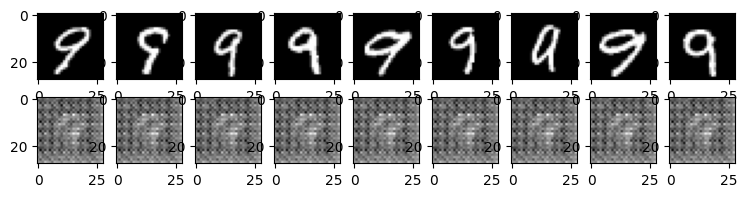

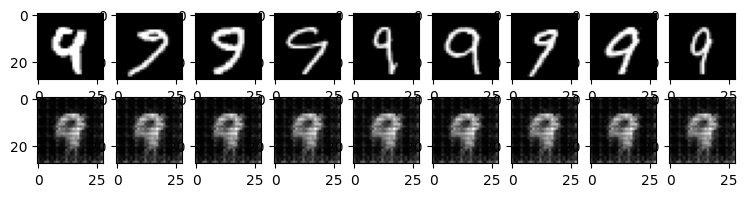

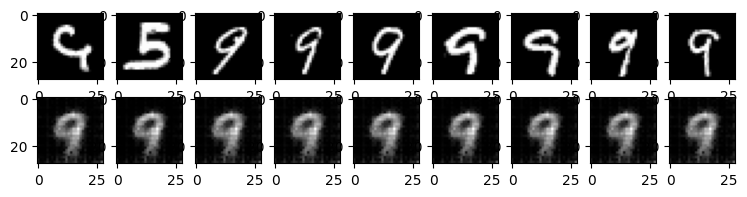

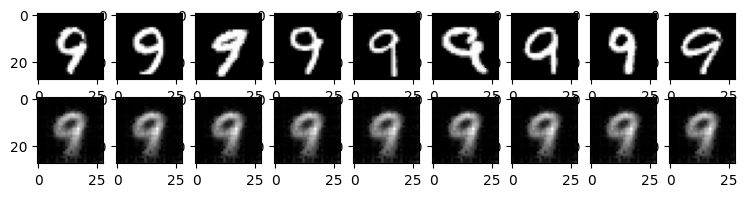

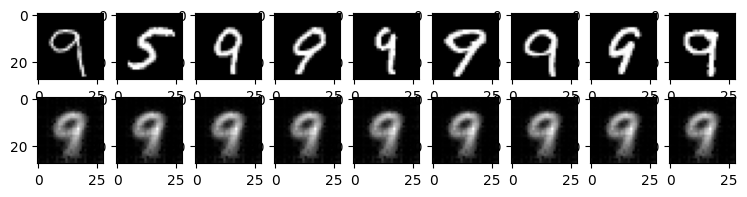

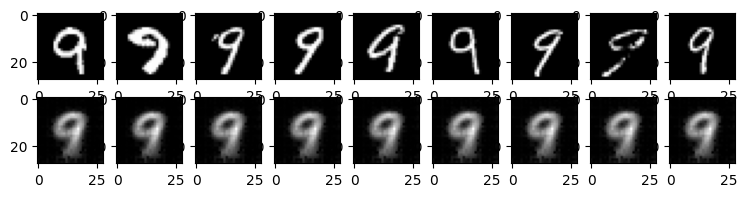

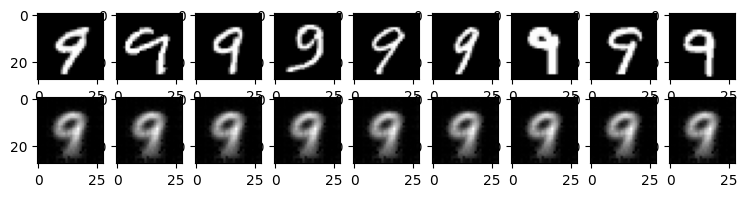

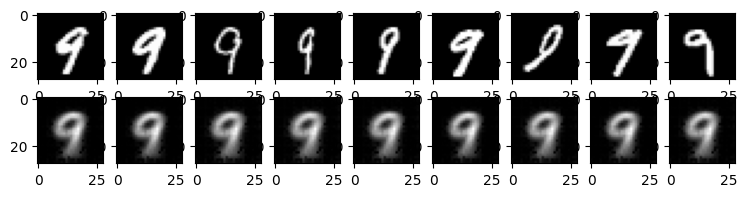

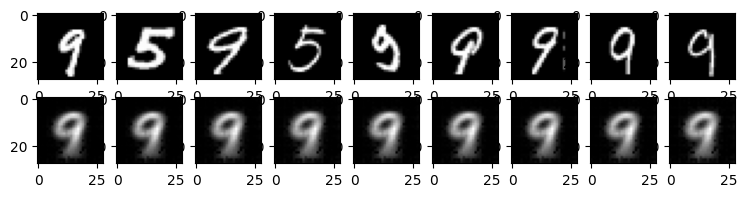

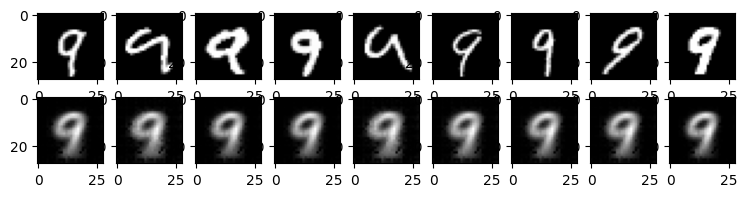

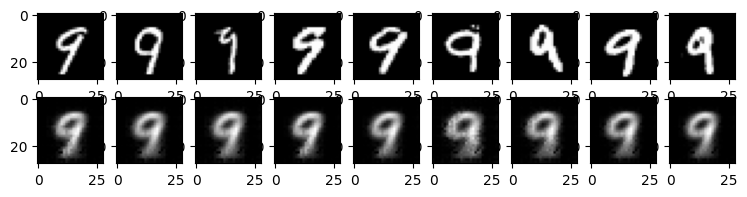

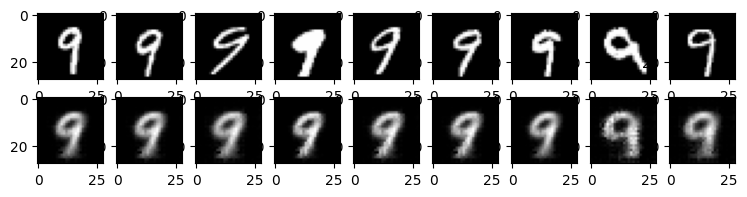

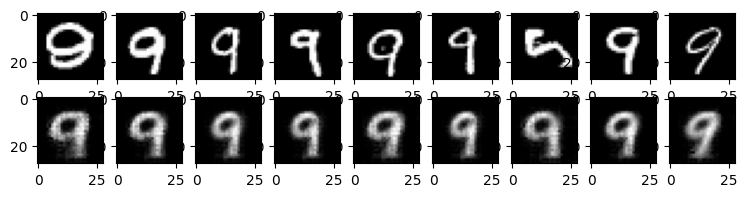

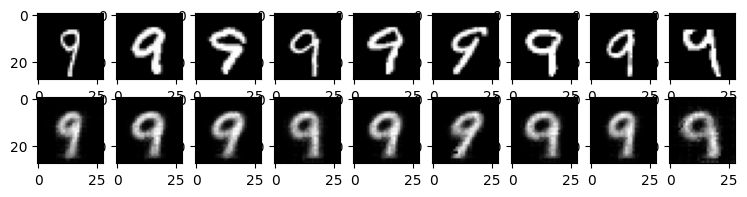

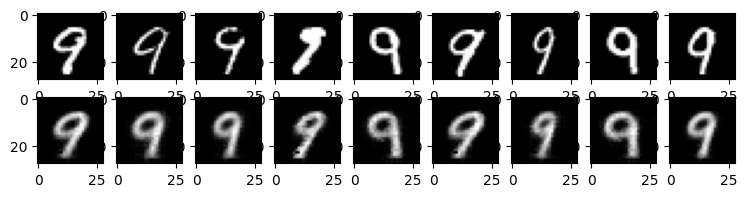

In [38]:
for k in range(0, num_epochs, 2):
    print("Epoch:",k)
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])



In [42]:

def calculate_losses(loader):
    normal = []
    anomalie = []
    for (img, label) in loader:
        loss = criterion(model(img), img)
        if label.item() == normal_label:
            normal.append(loss)
        else:
            anomalie.append(loss)
            
    normal.sort()
    anomalie.sort()

    normal = [round(tensor.tolist(),4) for tensor in normal]
    anomalie = [round(tensor.tolist(),4) for tensor in anomalie]
    return normal, anomalie

normal_train, anomalie_train = calculate_losses(train_loader_without_batch)
normal_test, anomalie_test = calculate_losses(test_loader)

print(normal_train)
print(anomalie_train)
print()
print(normal_test)
print(anomalie_test)


[0.0086, 0.0096, 0.0101, 0.0106, 0.0109, 0.011, 0.011, 0.0112, 0.0113, 0.0113, 0.0113, 0.0114, 0.0115, 0.0115, 0.0116, 0.0116, 0.0117, 0.0118, 0.0118, 0.0118, 0.0118, 0.0121, 0.0121, 0.0122, 0.0123, 0.0123, 0.0123, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0124, 0.0125, 0.0125, 0.0125, 0.0125, 0.0126, 0.0126, 0.0126, 0.0126, 0.0127, 0.0127, 0.0127, 0.0128, 0.0128, 0.0128, 0.0129, 0.0129, 0.0129, 0.013, 0.013, 0.013, 0.0131, 0.0132, 0.0132, 0.0132, 0.0132, 0.0132, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0133, 0.0134, 0.0134, 0.0134, 0.0134, 0.0134, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0135, 0.0136, 0.0136, 0.0136, 0.0136, 0.0137, 0.0137, 0.0137, 0.0138, 0.0138, 0.0138, 0.0138, 0.0138, 0.0138, 0.0138, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.0139, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.0141, 0.0141, 0.0141, 0.0141, 0.0141, 0.0141, 0.0141, 0.0141, 0.0142, 0.0142, 0.0142, 0.0142, 0.0142, 0.0143

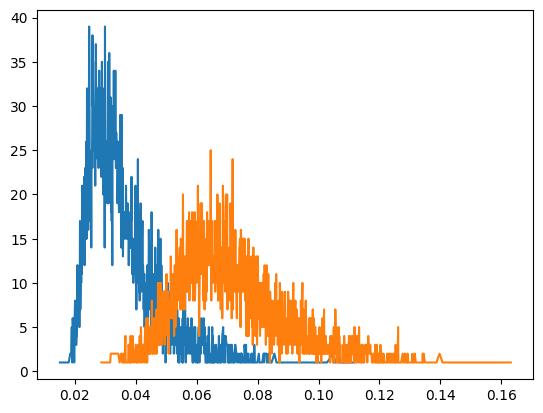

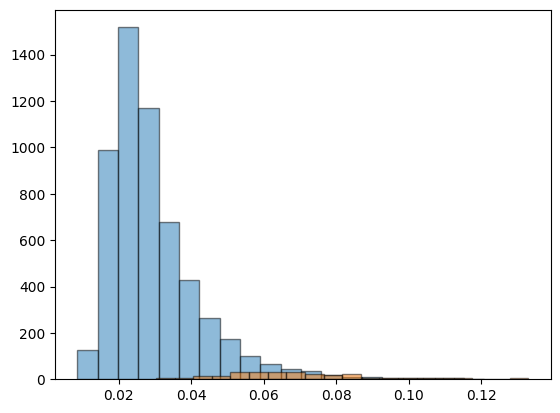

(array([  6.,  15.,  46.,  78., 125., 118.,  99.,  89.,  74.,  57.,  46.,
         43.,  44.,   9.,  18.,  15.,   3.,   4.,   1.,   2.]),
 array([0.0302  , 0.036025, 0.04185 , 0.047675, 0.0535  , 0.059325,
        0.06515 , 0.070975, 0.0768  , 0.082625, 0.08845 , 0.094275,
        0.1001  , 0.105925, 0.11175 , 0.117575, 0.1234  , 0.129225,
        0.13505 , 0.140875, 0.1467  ]),
 <BarContainer object of 20 artists>)

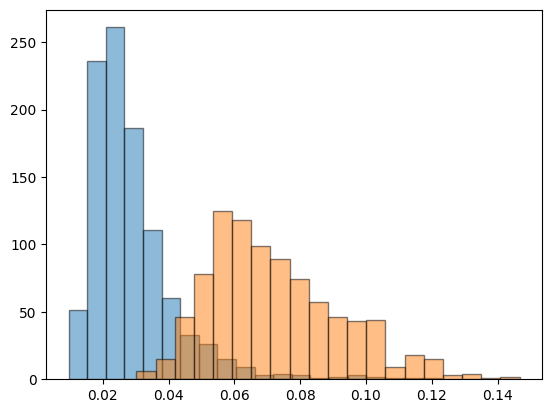

In [45]:
x = list(set(normal))
x.sort()
y = [normal.count(e) for e in x]

plt.plot(x,y)

x = list(set(anomalie))
x.sort()
y = [anomalie.count(e) for e in x]

plt.plot(x,y)

plt.show()

bins = 20
plt.hist(normal_train, alpha=0.5, bins=bins, label='Data 1', edgecolor='black')
plt.hist(anomalie_train, alpha=0.5, bins=bins, label='Data 2', edgecolor='black')

plt.show()

plt.hist(normal_test, alpha=0.5, bins=bins, label='Data 1', edgecolor='black')
plt.hist(anomalie_test, alpha=0.5, bins=bins, label='Data 2', edgecolor='black')